# Bus and Concatinated code Calculations.

## Includes

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import ticker as tick
import numpy as np
import pandas as pd
import statsmodels.stats.proportion as smp
import math
from scipy.stats import binom
from sklearn.linear_model import LinearRegression

from itertools import count as itercnt

import sys
import pickle
np.set_printoptions(threshold=sys.maxsize)

import mpmath

import glob
import json

from mpmath import *

## Repetition Code Performance

First we define some functions to determine the probability of the repetitions code, as well as the required size of a repetition code to obtain a given performance.

In [2]:
# Set the precision of mpmath to 100 digits.
mpmath.prec = 100
mpmath.mp.dps = 100

# This calculates the CDF of the binomial distribition at high precision
def binom_cdf(k,n,p):
    x2 = (1-mpmath.mpf(p))
    a = n - k
    b = k + 1
    v = x2**a * mpmath.hyp2f1(a, 1-b, a+1, x2, maxprec = 1000000) / a
    v /= mpmath.beta(a,b)
    return v

# This calculates the size of the repetition code required to hit a target error rate
def get_rep_code_probs(p,target, r = range(3, 1001, 2)):
    new_p = 0
    rep_len = 1
    for m in r:
        new_p = 1-binom_cdf((m-1)/2,m, p)
        rep_len = m
        if new_p < target: 
            break
    return  new_p, rep_len

## Surface code Performance
These functions return the surface code performance as described in the fits given in the paper.

In [3]:
def get_x_rate_step(dx, dz, p_in):
    A = 0
    B = 0
    C = 0
    if dx == 3:
        A = 500.0
        B = -700.0
        C = 250.0
    elif dx == 5:
        A = 26399.0
        B = -57295.0
        C = 18522.0
    elif dx == 7:
        A = 2.87E6
        B = -1.55E7
        C = 2.75E7
    fdx = dz*dz*A + dz*B + C
    
    powval = (dx + 1) // 2
    
    return fdx * pow(p_in, powval)/dz

def get_z_rate_step(dx, dz, p_in):
    alpha = 0.0
    beta = 0.0
    if dx == 3:
        alpha = 0.09
        beta = 95.0
    if dx == 5:
        alpha = 0.06
        beta = 110.0
    if dx == 7:
        alpha = 0.03
        beta = 125.0
    
    powval = (dx + 1) // 2
    
    return alpha * (dx - 0.5)/(dz - 0.5) * dz * pow(beta * p_in, powval)/dz

def get_square_rate_step(d, p_in):
    return 0.3 * pow(70*p_in, (d+1)//2)

## Bus Performance

### Functions
Here we define functions to calculate the performance of the surface code Bus.

In [4]:
# Calculate the width of the Surface code
def get_buswidth(d_sq, w, spaces):
    return d_sq* spaces + w * (spaces - 1)

# Calculate the number of steps required in the surface code bus
def get_bussteps(d_sq, w):
    return d_sq + w + 1

# Calculate the Bus error by computing the errors in the major contributing quantum volumes.
def get_bus_error(d_sq, w, spaces, p_in):
    return d_sq * get_x_rate_step(w, get_buswidth(d_sq, w, spaces), p_in) + 2 * w * get_x_rate_step(w, d_sq, p_in)

def bus_works(d_sq, w, spaces, p_in):
    return get_bus_error(d_sq,w,spaces,p_in) < 0.5

# Get the number of repetitions required to have equal error in the bus as in the 
def get_eq_m(d,w,n,p_in, cap=1001):
    bus_step_error = get_bus_error(d,w,n,p_in)
    sq_m_error = get_square_rate_step(d,p_in)*get_bussteps(d,w)
    if bus_step_error >= 0.5:
        raise RuntimeError(f"Bus error {bus_step_error} too high will not converge, d={d} w={w} n={n} p_in={p_in}")
    for m in range(1,cap,2):
        bus_r_error = 1- binom_cdf((m-1)/2,m,bus_step_error)
        sq_r_error = sq_m_error * m
#         print("   ", m , bus_r_error, sq_r_error,bus_r_error < sq_r_error)
        if (bus_r_error < sq_r_error):
            return m, bus_r_error, sq_r_error
    return m, bus_r_error, sq_r_error

Check some values to make sure they make sense.

In [5]:
print(get_x_rate_step(5,5,0.001))
print(get_square_rate_step(5, 0.001))
print(get_bus_error(33,5,2, 0.001))

7.84044e-05
0.00010290000000000002
0.06811506354417414


### Bus Boundary Figure

First we calculate the maximum possible bus lengths by iterating through different bus widths, lengths, and surface code patch dimensions and plot the results.

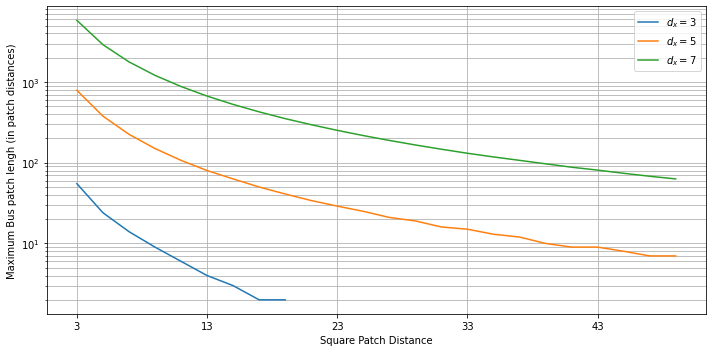

In [6]:
bus_lengths = {}
p_in = 0.001
for w in [3,5,7]:
    in_results = {}
    for d in range (3,50,2):
        for n in range(2,20000,1):
            if not bus_works(d,w,n,p_in):
                break
            in_results[d]=n
    bus_lengths[w] = in_results

fig, ((ax)) = plt.subplots(1,1)
ax.set_xscale("linear")
ax.set_yscale("log")
ax.set_xticks(range(3,1000,10))
plt.xlabel("Square Patch Distance")
plt.ylabel("Maximum Bus patch lengh (in patch distances)")
for w,v in bus_lengths.items():
    x = []
    y = []
    for key,value in v.items():
        x.append(key)
        y.append(value)
    plt.plot(x,y, label=f'$d_x = {w}$')
ax.grid(True, which="both", axis="both", ls = "-")
ax.legend()
fig = plt.gcf()
fig.set_size_inches(10,5)
fig.tight_layout()
fig.savefig("arch_images/bus_lengths.pdf")

## Bus Performance Figures
First we calculate the performance of the surface code bus, To save time we have a lower threshold on the bus errorr, which restrict the length of repetition code that we allow a search for, as very long repetition codes, as well as codes very close to threshold take significantly longer to compute we print the current working set to provide progress feedback.

In [ ]:
max_sc_degree = 31
max_bus_distance = 10000
per_iteration_error_threshold = 0.4
max_rc_iterations = 100000

bus_details = []
p_in = 0.001
for w in [3,5,7]:
    print(f"w={w}")
    for d in range (3,max_sc_degree,2):
        sys.stdout.write(f'd={d}, n=')
        sys.stdout.flush()
        for n in range(2,max_bus_distance,1):
            if get_bus_error(d,w,n,p_in) > per_iteration_error_threshold:
                break
            m, bus_r_error, sq_r_error = get_eq_m(d,w,n,p_in,max_rc_iterations)
            bus_step_error = get_bus_error(d,w,n,p_in)
            sq_m_error = get_square_rate_step(d,p_in)*get_bussteps(d,w)
            bus_details.append((w,d,n, bus_step_error, m , m*get_bussteps(d,w) , bus_r_error,10, sq_r_error))
            sys.stdout.write(f'{n}, ')
            sys.stdout.flush()
        print()
            

w=3
d=3, n=2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 
d=5, n=2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
d=7, n=2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 
d=9, n=2, 3, 4, 5, 6, 7, 
d=11, n=2, 3, 4, 5, 
d=13, n=2, 3, 
d=15, n=2, 
d=17, n=2, 
d=19, n=
d=21, n=
d=23, n=
d=25, n=
d=27, n=
d=29, n=
w=5
d=3, n=2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 13

d=3, n=2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717

2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083

4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4362, 4363, 4364, 4365, 4366, 4367, 4368, 4369, 4370, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449

d=5, n=2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717

d=7, n=2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

d=9, n=2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

d=13, n=2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

d=21, n=2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [ ]:
error_rates = {}
for v in bus_details:
    w,d,n, bus_step_error, m, total_time, bus_error_rate, ten, sq_r_error = v
    error_rates[(w,d,n)] = (bus_step_error, m, total_time, float(bus_error_rate), sq_r_error)
# print(error_rates)

w_map = {}
for (w,d,n),v in error_rates.items():
    if not w in w_map:
        w_map[w] = {}
    if not d in w_map[w]:
        w_map[w][d] = {}
    w_map[w][d][n] = v

### Generate the Figures

In [ ]:
for w, v1 in w_map.items():
    fig, ((ax)) = plt.subplots(3,1)
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[2].set_xscale("log")
    ax[2].set_yscale("log")
    ax[0].set_ylabel("Bus repetitions Required")
    ax[1].set_ylabel("Time for Bus Operation (SC rounds)")
    ax[2].set_xlabel("Bus Length (Square Patches)")
    ax[2].set_ylabel("Error Rates")

    for d,v2 in v1.items():
        x = []
        y = []
        for n,value in v2.items():
            x.append(n)
            y.append(value[1])
        ax[0].plot(x,y, label=f'$d = {d}$')
        
    for d,v2 in v1.items():
        x = []
        y = []
        for n,value in v2.items():
            x.append(n)
            y.append(value[2])
        ax[1].plot(x,y, label=f'$d = {d}$')
    
    for d,v2 in v1.items():
        x = []
        y = []
        for n,value in v2.items():
            x.append(n)
            y.append(value[4])
        ax[2].plot(x,y, label=f'$d = {d}$')
    ax[2].set_prop_cycle(None)
    for d,v2 in v1.items():
        x = []
        y = []
        for n,value in v2.items():
            x.append(n)
            y.append(value[3])
        ax[2].plot(x,y, ls=':')
#         ax[2].plot(x,y, label=f'$d = {d}$', ls=':')
    ax[0].grid(True, which="both", axis="both", ls = "-")
    ax[0].legend()
    ax[1].grid(True, which="both", axis="both", ls = "-")
    ax[1].legend()
    ax[2].grid(True, which="both", axis="both", ls = "-")
    ax[2].legend()
    fig = plt.gcf()
    fig.set_size_inches(10,15)
    fig.tight_layout()
    fig.savefig(f'arch_images/bus_rates{w}.pdf')

## Concatinated Code Calculations
### Surface code, and bus comparison functions
These Functions generate numbers to enable comparisons with the concatinated Codes.

In [ ]:
#this returns the probability of an error in a cnot between two adjacent surface code patches using latice surgery in
#the format wanted for the table of results
def getSCError(p,d):
    h = 2 * d -1
    b = 2*(2*d) -1
    block_size = (h+1)*b
    return d,"NA", b, get_square_rate_step(d, p) * d, block_size, block_size

#this returns the probability of an error during a single bus operation between two adjacent surface code patches.
def getSCBusError(p,d,w):
    h = (2*(d+w)) - 1
    block_size = h*(h + 1)
    m, bus_error, sq_error = get_eq_m(d,w,2,p, 3001)
    return d, w, h, sq_error, block_size,block_size

### Concatinated Stene code Functions
First The function that calculates the polynomial fit.

In [ ]:
# Stene probability fit polynomial using fit in paper
def stene_prob(p):
    return 2.23E4 * (p ** 2) - 3.5E6 * (p ** 3) + 1.7E8 * (p ** 4)

Then the Recursive function that calculates the performance of the stene codes concatinated with the surface code.

In [ ]:
def getLevelSteneProb(level, p, d, b_w, swap_bus, basebusl2, init=True):
    if level < 1: #there must be at least a single error
        return 0,0
    elif level == 1: #base case
        m, bus_error, sq_error = get_eq_m(d,b_w,2*(7 + 2),p, 1001)
        
        cnot_cost = stene_prob(sq_error * (1 + 3/(6*3))) #There are 6 stabilisers each has 3 bus slots, there are 3 slots to do a cnot 
        if swap_bus:
            swap_cost = stene_prob(sq_error * (1 + (18)/(6*3))) #Can do a swap, with the gaps by using 18 teleports into empty ancilla
        else:
            swap_cost = 3*cnot_cost
        return cnot_cost, swap_cost
    elif (level == 2) and basebusl2: #Secondary base case that directly uses the bus to perform operations on the second level of concatination
        num_sc_per_l1 = (7+4) #Can re-use the ancilla that are normally used to extract parity for cnots between l1 qubits.
        num_l1_per_l2 = 7+2+1 #two adjacent Steane codes at L2 only require maxumum transversal bus operations between them 
        
        short_m, bus_error_short, sq_error_short = get_eq_m(d,b_w,num_sc_per_l1,p, 1001)
        long_m, bus_error_long,  sq_error_long  = get_eq_m(d,b_w,num_sc_per_l1 * num_l1_per_l2,p, 1001)
        
        sq_m_error = get_square_rate_step(d,p)*get_bussteps(d,b_w)
        
        l1_cnot_steps = (3*6*short_m + 4*long_m) #There are 3 stabilisers each has 6 short bus slots, there are 4 long slots to do a cnot
        l1_teleport_steps = (3*6*short_m + 7*long_m) #There are 3 stabilisers each has 6 short bus slots, and a teleport is transversal with long slots.
        l1_prob_cnot = stene_prob(l1_cnot_steps * sq_m_error /(3*6)) 
        l1_prob_teleport = stene_prob(l1_teleport_steps * sq_m_error /(3*6)) 
        l2_prob_cnot = stene_prob(l1_prob_cnot * (1 + 3/(6*3))) #Add time to do CNOT between stabiliser operations as in L1
        l2_prob_swap = stene_prob((6*3*l1_prob_cnot + 18*l1_prob_teleport)/(6*3)) # The time created above allows for 1
        return l2_prob_cnot, l2_prob_swap
    else:
        cnot_cost_minus1 , swap_cost_minus1 = getLevelSteneProb(level-1, p,d,b_w,swap_bus,basebusl2, False)
        cnot_cost = stene_prob(((2*9 - 2) * swap_cost_minus1 + cnot_cost_minus1)) 
        swap_cost = stene_prob((2*9 - 1) * swap_cost_minus1)
        return cnot_cost, swap_cost

This function then recursively calculates the width used to enable qubit count estimates.

In [ ]:
def getLevelSteneWidthDistance(level, d, b_w, basebusl2, init = True):
    if level == 1:
        return (2 + 7 + 2) * (d + b_w)
    if level == 2 and basebusl2:
        return (7+4)*(7+2)* (d + b_w)
    else:
        return getLevelSteneWidthDistance(level-1, d, b_w, basebusl2, False) * 9

And finally we combine this together to create a function that combines the relevant information.

In [ ]:
def getBusSteneError(level,p,d,b_w, swap_bus = True, basebusl2 = True):
#     print(level,p,d,b_w, swap_bus, basebusl2)
    prob = getLevelSteneProb(level, p, d, b_w, swap_bus,basebusl2)
    
    block_w_d = getLevelSteneWidthDistance(level, d, b_w,basebusl2)
    block_h_d = d + b_w
    block_h = 2 * block_h_d - 1
    block_w = 2 * block_w_d - 1
    block_size = block_h * (block_w + 1)
    return level,d,b_w,block_h, prob, block_size,block_size

### Concatinated [[15,7,3]] CSS code functions

As in the Steane code, we have a polynomial fit function, a recursive function that uses the bus for the base case and swaps for higher cases, and uses gap ancilla to enable swaps without higher level errors during swaps.

In [ ]:
#[[15,7,3]] CSS code probility fit polynomial from paper
def fifteenSeven(p):
    return 8.0E5 * (p**2) - 6.0E8 * (p**3) + 14E10*(p**4)

def getLevelFifteenSevenProb(level, p, d, b_w, init=True):
    if level < 1:
        return 0,0
    if level == 1:
        m, bus_error, sq_error = get_eq_m(d,b_w,2*15 + 5,p, 3001)
        
        cnot_cost = fifteenSeven(sq_error * (1 + (18/(4*15)))) #4 stabs, each 15 bus slots, 18 slots to do a cnot
        swap_cost = fifteenSeven(sq_error * (1 + (36/(4*15)))) #4 stabs, each 15 bus slots, 36 slots to do a swap
        return cnot_cost, swap_cost
    else:
        cnot_cost_minus1 , swap_cost_minus1 = getLevelFifteenSevenProb(level-1, p,d,b_w, False)
        cnot_cost = fifteenSeven(((2*18 - 2) * swap_cost_minus1 + cnot_cost_minus1))
        swap_cost = fifteenSeven(((2*18 - 1) * swap_cost_minus1))
        return cnot_cost, swap_cost

def getLevelFifteenSevenDistance(level, d, b_w, init=True):
    if level == 1:
        return (3+15+2)* (d + b_w)
    else:
        return getLevelFifteenSevenDistance(level-1, d, b_w, False) * 18
    
def getBusFifteenSevenError(level,p,d,b_w):
    prob = getLevelFifteenSevenProb(level, p, d, b_w)
    
    block_w_d = getLevelFifteenSevenDistance(level, d, b_w)
    block_h_d = d + b_w
    block_h = 2 * block_h_d - 1
    block_w = 2 * block_w_d - 1
    block_size = block_h * (block_w + 1)
    return level, d,b_w,block_h, prob, block_size,block_size/(7**level)

def printErrorLine(input_tuple):
    level, distance, b_w, block_h, prob, block_size, qubit_density = input_tuple
    print(f"L{level}, d:{distance: >2d}, w:{b_w}, h:{block_h}, p:{prob[0]:.2e}, n_q:{float(block_size):.2e}, d_q:{float(qubit_density):.2e}")

### Generate the Table of results
The degrees here were chosen to be the best possible at each level of concatination

In [ ]:
p= 1E-3
print("p =",p)
print(getSCError(p,27))
print(getSCBusError(p, 31,5))
print("--")
printErrorLine(getBusSteneError(1,p,21,7))
printErrorLine(getBusSteneError(2,p,15,7))
printErrorLine(getBusSteneError(3,p,13,7))
printErrorLine(getBusSteneError(7,p,11,7))
print("--")
printErrorLine(getBusFifteenSevenError(1,p,23,7))
printErrorLine(getBusFifteenSevenError(2,p,21,7))
printErrorLine(getBusFifteenSevenError(3,p,19,7))
printErrorLine(getBusFifteenSevenError(4,p,17,7))

print()    
p= 4.7E-4
print("p = ",p)
print(getSCError(p,21))
print(getSCBusError(p, 23,5))
print("--")
printErrorLine(getBusSteneError(1,p,15,5))
printErrorLine(getBusSteneError(2,p,11,5))
printErrorLine(getBusSteneError(4,p, 9,5))
print("--")
printErrorLine(getBusFifteenSevenError(1,p,17,5))
printErrorLine(getBusFifteenSevenError(2,p,15,5))
printErrorLine(getBusFifteenSevenError(3,p,13,5))

print()    
p= 2.2E-4
print("p = ",p)
print(getSCError(p,17))
print(getSCBusError(p, 19,3))
print("--")
printErrorLine(getBusSteneError(1,p,13,3))
printErrorLine(getBusSteneError(2,p, 9,5))
printErrorLine(getBusSteneError(4,p, 7,5))
print("--")
printErrorLine(getBusFifteenSevenError(1,p,13,5))
printErrorLine(getBusFifteenSevenError(2,p,13,3))
printErrorLine(getBusFifteenSevenError(3,p,11,3))

print()    
p= 1.0E-4
print("p = ",p)
print(getSCError(p,15))
print(getSCBusError(p, 15,3))
print("--")
printErrorLine(getBusSteneError(1,p,11,3))
printErrorLine(getBusSteneError(2,p, 7,3))
printErrorLine(getBusSteneError(9,p, 5,3))
print("--")
printErrorLine(getBusFifteenSevenError(1,p,11,3))
printErrorLine(getBusFifteenSevenError(3,p,9,3))

In [ ]:
p= 1E-3
print("p =",p)
print(getSCError(p,27))
print(getSCBusError(p, 31,5))
print("--")
printErrorLine(getBusSteneError(1,p,21,7))
printErrorLine(getBusSteneError(2,p,15,7))
printErrorLine(getBusSteneError(3,p,13,7))
printErrorLine(getBusSteneError(7,p,11,7))
print("--")
printErrorLine(getBusFifteenSevenError(1,p,23,7))
printErrorLine(getBusFifteenSevenError(2,p,21,7))
printErrorLine(getBusFifteenSevenError(3,p,19,7))
printErrorLine(getBusFifteenSevenError(4,p,17,7))

print()    
p= 4.7E-4
print("p = ",p)
print(getSCError(p,21))
print(getSCBusError(p, 23,5))
print("--")
printErrorLine(getBusSteneError(1,p,15,5))
printErrorLine(getBusSteneError(2,p,11,5))
printErrorLine(getBusSteneError(4,p, 9,5))
print("--")
printErrorLine(getBusFifteenSevenError(1,p,17,5))
printErrorLine(getBusFifteenSevenError(2,p,15,5))
printErrorLine(getBusFifteenSevenError(3,p,13,5))

print()    
p= 2.2E-4
print("p = ",p)
print(getSCError(p,17))
print(getSCBusError(p, 19,3))
print("--")
printErrorLine(getBusSteneError(1,p,13,3))
printErrorLine(getBusSteneError(2,p, 9,5))
printErrorLine(getBusSteneError(4,p, 7,5))
print("--")
printErrorLine(getBusFifteenSevenError(1,p,13,5))
printErrorLine(getBusFifteenSevenError(2,p,13,3))
printErrorLine(getBusFifteenSevenError(3,p,11,3))

print()    
p= 1.0E-4
print("p = ",p)
print(getSCError(p,15))
print(getSCBusError(p, 15,3))
print("--")
printErrorLine(getBusSteneError(1,p,11,3))
printErrorLine(getBusSteneError(2,p, 7,3))
printErrorLine(getBusSteneError(9,p, 5,3))
print("--")
printErrorLine(getBusFifteenSevenError(1,p,11,3))
printErrorLine(getBusFifteenSevenError(3,p,9,3))